In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [2]:
import os
os.chdir('../methods')
import lsci, supr, conf
os.chdir('../examples')

In [3]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = data[(lag + horizon):][:,None]
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 1)
    return x_t.copy(), y_t.copy()

In [4]:
def split_cal(yval_hat, yval):
    nval = yval.shape[0]
    nval2 = yval.shape[0]//2

    yval = yval.reshape(nval, -1)
    yval_hat = yval_hat.reshape(nval, -1)
    
    rval = yval - yval_hat
    rval1 = rval[:nval2]
    rval2 = rval[nval2:]
    yval1 = yval[:nval2]
    yval2 = yval[nval2:]
    yval_hat1 = yval_hat[:nval2]
    yval_hat2 = yval_hat[nval2:]
    return rval1, rval2, yval1, yval2, yval_hat1, yval_hat2

def project_cal(rval1, rval2, yval_hat2, nproj, pca_state):
    pca_state = pcax.fit(rval1, n_components=nproj)
    rval_proj = pcax.transform(pca_state, rval2)
    yval_hat_proj = pcax.transform(pca_state, yval_hat2)
    return rval_proj, yval_hat_proj

def project_test(ytest_hat, ytest = None, state = None):
    ntest = ytest_hat.shape[0]

    # reshape and compute residuals
    ytest_hat = ytest_hat.reshape(ntest, -1)
    ytest_hat_proj = pcax.transform(pca_state, ytest_hat)

    if ytest is not None:
        ytest = ytest.reshape(ntest, -1)
        rtest = ytest - ytest_hat
        rtest_proj = pcax.transform(pca_state, rtest)
        return rtest, rtest_proj, ytest_hat_proj

    return ytest_hat_proj

In [14]:
def risk_control(lower, upper, residual):
    return jnp.mean((residual > lower)*(residual < upper))

In [5]:
class ANO_layer(nnx.Module):
  def __init__(self, width, rngs: nnx.Rngs):
    self.linear = nnx.Linear(width, width, rngs=rngs)
    # self.bn = nnx.BatchNorm(dmid, rngs=rngs)
    # self.dropout = nnx.Dropout(0.2, rngs=rngs)
    self.linear_out = nnx.Linear(width, width, rngs=rngs)

  def __call__(self, x):
    # channel mix
    h = self.linear(x)

    # spatial mix
    g = jnp.mean(x, axis = (1, 2))[:,None,None,:]

    # sum
    x = h + g
    x = nnx.relu(x)

    return self.linear_out(x)

class encode_layer(nnx.Module):
  def __init__(self, in_dim, out_dim, rngs):
    self.linear = nnx.Linear(in_dim, out_dim, rngs=rngs)

  def __call__(self, x):
    return self.linear(x)

class DeepANO(nnx.Module):
  def __init__(self, in_dim, width, out_dim, rngs):
    self.encode_layer = encode_layer(in_dim, width, rngs)
    self.ano1 = ANO_layer(width, rngs)
    self.ano2 = ANO_layer(width, rngs)
    self.ano3 = ANO_layer(width, rngs)
    self.decode_layer = encode_layer(width, out_dim, rngs)

  def __call__(self, x):
    x = self.encode_layer(x)
    x = self.ano1(x)
    x = self.ano2(x)
    x = self.ano3(x)
    x = self.decode_layer(x)
    return x

@nnx.jit  # Automatic state management
def train_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(x)
    y_diff = jnp.diff(y_pred, axis = 0)
    return jnp.mean((y_pred - y) ** 2) + jnp.mean(y_diff**2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # In place updates.

  return loss

@nnx.jit  # Automatic state management
def refine_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(model(x))
    return jnp.mean((y_pred - y) ** 2)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # In place updates.

  return loss

In [6]:
key = random.PRNGKey(0)
t = jnp.linspace(0, 1, 100)
f = jnp.sin(2 * math.pi * t)

s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.cos(s - 2*math.pi)

x = amp[:,None] * f[None,:]
x = x + 0.25 * (1.15 + sd)[:,None] * random.normal(key, x.shape)

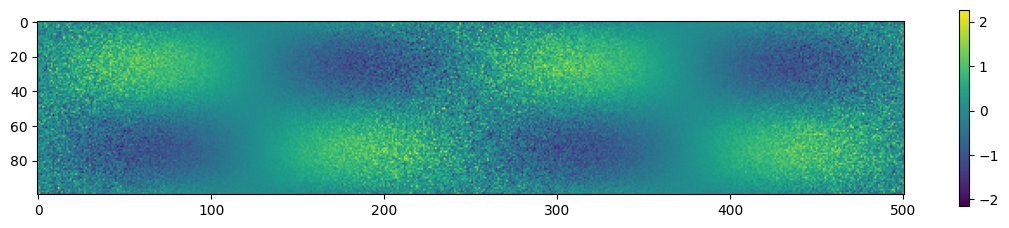

In [7]:
plt.figure(figsize = (10, 4), constrained_layout = True)
plt.imshow(x.T)
plt.colorbar(shrink = 0.5)
plt.show()

In [8]:
x, y = split_data(x, 1, 1)
x = x[:,:,:,None]
y = y[:,:,:,None]

In [22]:
model = DeepANO(1, 50, 1, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3)) 

epochs = 50
nbat = 50
for _ in trange(epochs):
  for i in trange(len(x)//nbat, leave = False):
    xi = x[i*nbat:(i+1)*nbat]
    yi = y[i*nbat:(i+1)*nbat]

    loss = train_step(model, optimizer, xi, yi)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
key = random.PRNGKey(1)
t = jnp.linspace(0, 1, 100)
f = jnp.sin(2 * math.pi * t)

s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.cos(s - 2*math.pi)

x = amp[:,None] * f[None,:]
x = x + 0.25 * (1.15 + sd)[:,None] * random.normal(key, x.shape)

x, y = split_data(x, 1, 1)
x = x[:,:,:,None]
y = y[:,:,:,None]

yhat = model(x)

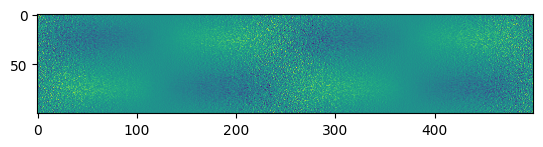

In [24]:
res = (yhat - y).squeeze()
plt.imshow(res.T)
plt.show()

res = jnp.abs(yhat - y).squeeze()
k = jnp.quantile(res, 0.91, axis = 0)

In [25]:
key = random.PRNGKey(2)
t = jnp.linspace(0, 1, 100)
f = jnp.sin(2 * math.pi * t)

s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.cos(s - 2*math.pi)

x = amp[:,None] * f[None,:]
x = x + 0.25 * (1.15 + sd)[:,None] * random.normal(key, x.shape)

x, y = split_data(x, 1, 1)
x = x[:,:,:,None]
y = y[:,:,:,None]

yhat = model(x)

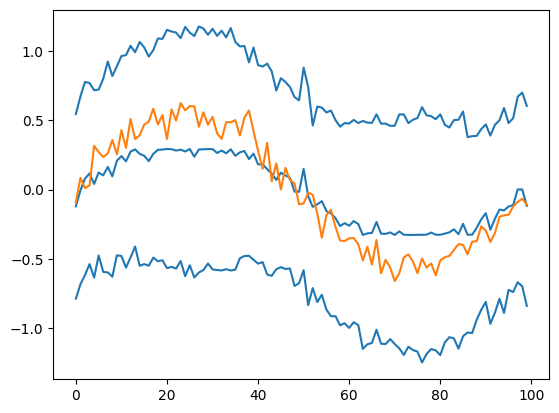

In [26]:
j = 100
yhatj = yhat[j].squeeze()
yj = y[j].squeeze()

plt.plot(yhatj + k, c = 'C0')
plt.plot(yhatj - k, c = 'C0')
plt.plot(yhatj, c = 'C0')
plt.plot(yj.squeeze(), c = 'C1')

In [27]:
risk = jnp.mean(((y.squeeze() < yhat.squeeze() + k)*(y.squeeze() > yhat.squeeze() - k)), axis = 1)

Array(0.90893996, dtype=float32)

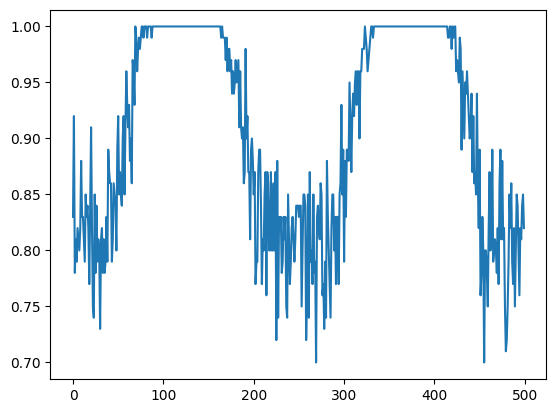

In [28]:
plt.plot(risk)
jnp.mean(risk)

In [56]:
key1 = random.PRNGKey(0)
key2 = random.PRNGKey(0)
key3 = random.PRNGKey(0)

t = jnp.linspace(0, 1, 100)
s = jnp.linspace(-2*math.pi, 2*math.pi, 501)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

In [57]:
model = DeepANO(1, 50, 1, nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3)) 

epochs = 50
nbat = 50
for _ in trange(epochs):
    for i in trange(len(f)//nbat, leave = False):
        xi = xtrain[i*nbat:(i+1)*nbat]
        yi = ytrain[i*nbat:(i+1)*nbat]

        loss = train_step(model, optimizer, xi, yi)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [58]:
yval_hat = model(xval)
ytest_hat = model(xtest)

In [69]:
nval = yval.shape[0]
nval2 = yval.shape[0]//2
ntest = ytest_hat.shape[0]
# nlat, nlon = 32, 64
nproj = 90

# split calibration dataset
yval = yval.reshape(nval, -1)
yval_hat = yval_hat.reshape(nval, -1)
rval = yval - yval_hat
rval1, rval2, yval1, yval2, yval_hat1, yval_hat2 = split_cal(yval_hat, yval)

# process test dataset
ytest = ytest.reshape(ntest, -1)
ytest_hat = ytest_hat.reshape(ntest, -1)
# ytest_quant = ytest_quant.reshape(ntest, -1)
rtest = ytest - ytest_hat

# project calibration and test
pca_state = pcax.fit(rval1, n_components=nproj)
rval_proj2, yval_hat_proj2 = project_cal(rval1, rval2, yval_hat2, nproj, pca_state)
rtest, rtest_proj, ytest_hat_proj = project_test(ytest_hat, ytest, pca_state)

In [193]:
gamma1 = 0.2
gamma2 = 0.5
alpha = 0.1
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval2 + 1))/(gamma1*nval2)
alpha2 = 1 - jnp.ceil((1-alpha) * (gamma2*nval2 + 1))/(gamma2*nval2)

lweight1 = lsci.local_weights(pcax.transform(pca_state, yval_hat2), 
                        pcax.transform(pca_state, ytest_hat), 
                        gamma1)
lweight2 = lsci.local_weights(pcax.transform(pca_state, yval_hat2), 
                        pcax.transform(pca_state, ytest_hat), 
                        gamma2)

In [194]:
rval_proj2.shape, lweight1[0].shape

((250, 90), (250,))

In [195]:
k = lsci.local_quantile_vmap(rval_proj2, 1 - alpha, lweight1[0])
lsc1_lower = ytest_hat_proj[0] - k
lsc1_upper = ytest_hat_proj[0] + k

In [200]:
tdepth = jnp.mean(lsci.local_tukey_self(rval_proj2, rval_proj2, lweight1[50]), axis = 0)
rval_proj3 = rval_proj2[tdepth > jnp.quantile(tdepth, 0.09)]
rval3 = pcax.recover(pca_state, rval_proj3)

In [201]:
rtest.shape

(500, 100)

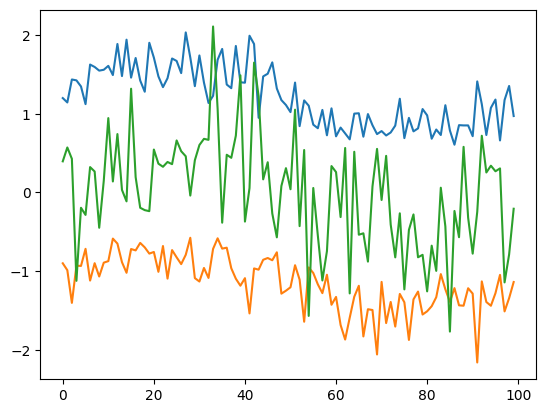

In [202]:
plt.plot(jnp.max(rval3, axis = 0))
plt.plot(jnp.min(rval3, axis = 0))
plt.plot(rtest[50].squeeze())
# plt.plot(pcax.recover(pca_state, jnp.min(rval_proj3, axis = 0))[0])
plt.show()

In [235]:
alpha = 0.1

lsc1_rc = []
lsc1_width = []

lsc2_rc = []
lsc2_width = []

conf_rc = []
conf_width = []

# uqn1_lower, uqn1_upper = uqno_band(ytest_quant, lam_uqno)
# uqn2_lower, uqn2_upper = uqno_band(ytest_quant, 0.75*lam_uqno)
conf_lower, conf_upper = conf.conf_band(rval2, pca_state, alpha)
# supr_lower, supr_upper = supr_band(rval2, alpha)

# for i in trange(ytest.shape[0]):
for i in trange(0, 200):
    # LSCI (sparse)
    lsc1_lower, lsc1_upper = lsci.lsci_band(rval2, lweight1[i], pca_state, alpha1, 1000)
    lsc1_rc.append(risk_control(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))

#     k = lsci.local_quantile_vmap(rval_proj2, alpha, lweight1[i])
#     lsc1_lower = ytest_hat[i] + pcax.recover(pca_state, -k)
#     lsc1_upper = ytest_hat[i] + pcax.recover(pca_state, k)

#     tdepth = jnp.mean(lsci.local_tukey_self(rval_proj2, rval_proj2, lweight1[i]), axis = 0)
#     rval_proj3 = rval_proj2[tdepth > jnp.quantile(tdepth, 0.0)]
#     rval3 = pcax.recover(pca_state, rval_proj3)
#     lsc1_lower = jnp.min(rval3, axis = 0)
#     lsc1_upper = jnp.max(rval3, axis = 0)
    
#     lsc1_rc.append(risk_control(lsc1_lower, lsc1_upper, rtest[i]))

    # CONF 
    conf_rc.append(risk_control(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
conf_rc = np.array(conf_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)

conf_width = np.array(conf_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)

  0%|          | 0/200 [00:00<?, ?it/s]

In [247]:
alpha = 0.1

lsc1_rc = []
lsc1_width = []

lsc2_rc = []
lsc2_width = []

conf_rc = []
conf_width = []

lsci_lower = []
lsci_upper = []

# uqn1_lower, uqn1_upper = uqno_band(ytest_quant, lam_uqno)
# uqn2_lower, uqn2_upper = uqno_band(ytest_quant, 0.75*lam_uqno)
conf_lower, conf_upper = conf.conf_band(rval2, pca_state, alpha)
# supr_lower, supr_upper = supr_band(rval2, alpha)

# for i in trange(ytest.shape[0]):
for i in [0, 50, 100]:
    # LSCI (sparse)
    lsc1_lower, lsc1_upper = lsci.lsci_band(rval2, lweight1[i], pca_state, alpha1, 1000)
    
    lsci_lower.append(lsc1_lower)
    lsci_upper.append(lsc1_upper)

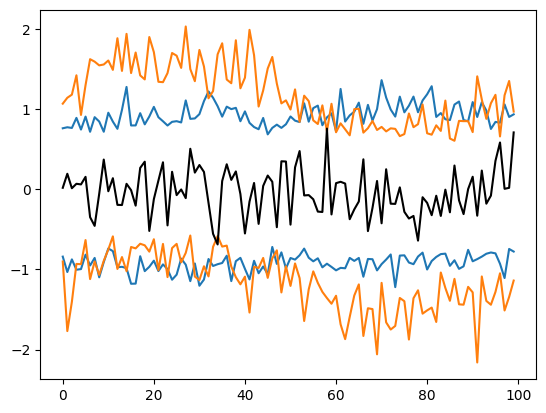

In [250]:
plt.plot(lsci_lower[0], c = 'C0')
plt.plot(lsci_upper[0], c = 'C0')
plt.plot(conf_lower, c = 'C1')
plt.plot(conf_upper, c = 'C1')

plt.plot(rtest[0].squeeze(), c = 'black')
# plt.plot(f[50].squeeze(), c = 'black')
plt.show()

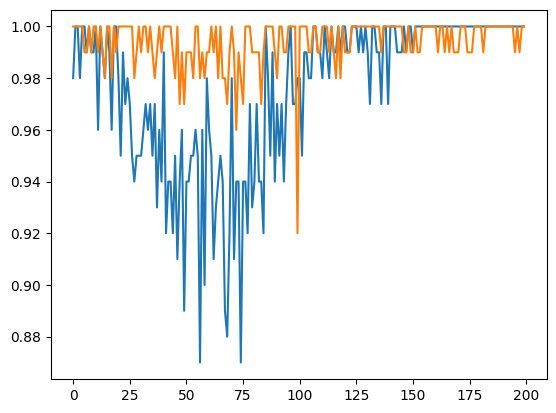

In [239]:
plt.plot(conf_rc)
plt.plot(lsc1_rc)
plt.show()